# CNN-Kim Model
I can't get it exactly the same now because I'm using custom-trained word vectors instead of pre-trained ones, but I can still try to build a similar architecture.

Since there are different variations of his model, I'll start with a model with the following architecture:
- Using custom-trained word vectors (dimension = 200)
- Keeping those word vectors static during the trainin process (maybe - TBD while implementing)
- Single-channel
- Filter windows height of 3, 4, 5 with 100 feature maps each
- MaxPooling to extract the features from each feature map
- Dropout rate of 0.5
- ReLu activation function 

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import ast
import tensorflow as tf
# from tensorflow_addons.metrics.hamming import hamming_loss_fn
# from tensorflow_addons.metrics import HammingLoss
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Dense, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Check that a GPU is available
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load in the data

In [3]:
# Load in the data
data_list = [a, b, c, d, e, f, g, h, i ,f] = [None, None, None, None, None, None, None, None, None, None]
data_location = '../Datasets/Amazon-Cat13K/processed/' 
for i in range(len(data_list)):
    data_list[i] = pd.read_csv(data_location + f'tokenized_no{i + 1}.csv', encoding='latin1')
    
# Concatenate all the data and reset the index
data = pd.concat(data_list, sort=False)
data = data.reset_index()

In [4]:
# Convery tringged arrays to arrays
data['tokenized_title_and_description'] = data['tokenized_title_and_description'].apply(lambda stringged_array: ast.literal_eval(stringged_array))
data['labels'] = data['labels'].apply(lambda stringged_array: ast.literal_eval(stringged_array))

In [5]:
# Check the first 3 rows
data.head(n=3)

,index,item_id,tokenized_title_and_description,labels
0,0,ID:B0027DQHA0,"[13001, 3280, 4417, 19, 239, 214, 1203, 1, 295...","[Music, Movies & TV, Classical, TV]"
1,1,ID:0756400120,"[386, 14728, 40, 5865, 10, 493, 1180, 2959, 3,...","[Short Stories, Science Fiction & Fantasy, Ant..."
2,2,ID:B00024YAOQ,"[634, 153, 56, 73, 5, 95, 1, 813, 3, 4, 3385, ...","[Business Life, Business & Investing, Books, M..."


In [6]:
# Check the shape
data.shape

(149426, 4)

In [7]:
# Load in the embedding matrix
embedding_matrix = np.loadtxt(data_location + 'embedding_matrix.csv', delimiter=',')

In [8]:
# Check the embedding matrix size
embedding_matrix.shape

(20000, 200)

### Prepare the X data

In [9]:
sequences = list(data['tokenized_title_and_description'])

In [10]:
# Add padding to the sequences
MAX_SEQUENCE_LENGTH = 500
padded_sequences = pad_sequences(sequences,
                                 maxlen=MAX_SEQUENCE_LENGTH,
                                 padding='post') # Add padding to the end if needs padding

In [11]:
# Get the data
X = padded_sequences

### Prepare the y data

In [12]:
# Get the labels
labels = list(data['labels'])

In [13]:
# Convert the tages into a binary vectors
mlb = MultiLabelBinarizer()
binary_vectors = mlb.fit_transform(labels)

In [14]:
# Have a look at the number of tags for the first 5 set of labels
for i in range(5):
    print(sum(binary_vectors[i]))

4
9
4
3
2


In [15]:
# Confirm that against the actual labels
labels[0:5]

[['Music', 'Movies & TV', 'Classical', 'TV'],
 ['Short Stories',
  'Science Fiction & Fantasy',
  'Anthologies & Literary Collections',
  'Books',
  'Anthologies',
  'Literature & Fiction',
  'United States',
  'Science Fiction',
  'General'],
 ['Business Life',
  'Business & Investing',
  'Books',
  'Motivation & Self-Improvement'],
 ['Aquariums', 'Fish & Aquatic Pets', 'Pet Supplies'],
 ['Movies', 'Movies & TV']]

### Prepare the data for training and testing

In [16]:
# Get the data
X = padded_sequences
y = binary_vectors

In [17]:
# Create the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [18]:
# Check X train and X test
print(f'X train shape: {X_train.shape}')
print(f'X test shape: {X_test.shape}')

X train shape: (112069, 500)
X test shape: (37357, 500)


In [19]:
# Check y train and y test
print(f'y train shape: {y_train.shape}')
print(f'y test shape: {y_test.shape}')

y train shape: (112069, 10873)
y test shape: (37357, 10873)


### Create the embedding layer

In [20]:
# Create the embedding layer definition
class PretrainedEmbedding(tf.keras.layers.Layer):
    """Non-trainable embedding layer."""

    def __init__(self, embeddings, dropout_rate=0.2, **kwargs):
        """"Instantiate the layer using a pre-defined embedding matrix."""
        super().__init__(**kwargs)
        self.embeddings = tf.constant(embeddings)
        # if you want to add some dropout (or normalization, etc.)
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def call(self, inputs, training=None):
        """Embed some input tokens and optionally apply dropout."""
        output = tf.nn.embedding_lookup(self.embeddings, inputs)
        return self.dropout(output, training=training)

### Define the model layers

In [21]:
# Define the model layers
i = Input(shape=(MAX_SEQUENCE_LENGTH), dtype=tf.int64)
x = PretrainedEmbedding(embedding_matrix, dropout_rate=0)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(y_train.shape[1], activation='softmax')(x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [22]:
# Build the model
model = Model(i, x)

In [23]:
# Have a look at the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
pretrained_embedding (Pretra (None, 500, 200)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 32)           19232     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 166, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 164, 64)           6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 54, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 52, 128)           24704 

### Define how the model should be trained

In [25]:
# Define how the model should be trained
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=[Precision(), Recall()])

### Train the model

In [27]:
# Train the model
result = model.fit(X_train, y_train,
                   epochs=5,
                   validation_data=(X_test, y_test));

Train on 112069 samples, validate on 37357 samples
Epoch 1/5
112069/112069 [==============================] - 71s 632us/sample - loss: 0.0029 - precision: 1.0000 - recall: 9.7077e-05 - val_loss: 0.0026 - val_precision: 0.9592 - val_recall: 2.4875e-04
Epoch 2/5
112069/112069 [==============================] - 70s 624us/sample - loss: 0.0025 - precision: 0.9531 - recall: 0.0010 - val_loss: 0.0024 - val_precision: 0.9418 - val_recall: 0.0022
Epoch 3/5
112069/112069 [==============================] - 84s 748us/sample - loss: 0.0024 - precision: 0.9448 - recall: 0.0029 - val_loss: 0.0023 - val_precision: 0.9528 - val_recall: 0.0049
Epoch 4/5
112069/112069 [==============================] - 75s 673us/sample - loss: 0.0023 - precision: 0.9548 - recall: 0.0043 - val_loss: 0.0023 - val_precision: 0.9486 - val_recall: 0.0047
Epoch 5/5
112069/112069 [==============================] - 83s 741us/sample - loss: 0.0022 - precision: 0.9574 - recall: 0.0050 - val_loss: 0.0022 - val_precision: 0.9569 - 

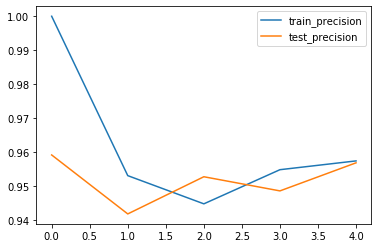

In [29]:
# Plot the precision metric at each itteration
plt.plot(result.history['precision'], label='train_precision');
plt.plot(result.history['val_precision'], label='test_precision');
plt.legend();

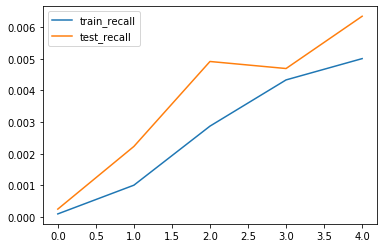

In [30]:
# Plot the recall metric at each itteration
plt.plot(result.history['recall'], label='train_recall');
plt.plot(result.history['val_recall'], label='test_recall');
plt.legend();